# HTGR Micro-Core Quadrant Power

**Input**


- `theta_{1}`: Angle of control drum in quadrant 1 (degrees) 
- `theta_{2}`: Angle of control drum in quadrant 1 (degrees) 
- `theta_{3}`: Angle of control drum in quadrant 2 (degrees)  
- `theta_{4}`: Angle of control drum in quadrant 2 (degrees)
- `theta_{5}`: Angle of control drum in quadrant 3 (degrees)
- `theta_{6}`: Angle of control drum in quadrant 3 (degrees)
- `theta_{7}`: Angle of control drum in quadrant 4 (degrees)  
- `theta_{8}`: Angle of control drum in quadrant 4 (degrees)  



**Output** 

- `FluxQ1` : Neutron flux in quadrant 1 ($\frac{neutrons}{cm^{2} s}$)
- `FluxQ2` : Neutron flux in quadrant 2 ($\frac{neutrons}{cm^{2} s}$)
- `FluxQ3` : Neutron flux in quadrant 3 ($\frac{neutrons}{cm^{2} s}$)
- `FluxQ4` : Neutron flux in quadrant 4 ($\frac{neutrons}{cm^{2} s}$)


# Overview
The data set consists of about 3000 data points with 8 inputs and 5 outputs. This data set increases in size from about 800 samples to about 3000 samples after producing more data points using reactor symmetries. The data set featured in this work was based around the
HOLOS-Quad reactor design. This reactor implements modular construction where seperate units can be transported independently and assembled at the specified location.  The HOLOS-Quad core is specifically a 22 MWt high-temperature
gas-cooled microreactor (HTGR) which is controlled by 8 cylindrical control drums. It utilizes TRISO fuel particles contained in hexagonal graphite blocks used as a moderator. These graphite blocks have channels where helium gas can pass through for cooling. The image below shows a radial slice of the reactor. [1] 

The main importance of this data set is the influence on the control drums on the neutron flux. The drums control reactivity by rotating to vary the proximity of $B_{4} C$ on a portion of their outer edges to the fueled region of the core. Perturbations of the control drums in tern causes the core power shape to shift leading to complexe power distributions. Therefore, predictions of control drum reactivity worths for arbitrary configurations makes this problem to be nontrivial. [1] 

Each sample in this dataset has 8 control drum angles where each angle was selected from a uniform random distribution spanning [− 180◦,180◦] and the corresponding fluxes in each of the four quadrants is calculated using the Serpent code.
The considerably larger dataset is needed because of the larger number of degrees of freedom associated with general statistical models such as deep neural networks (DNN). [1]


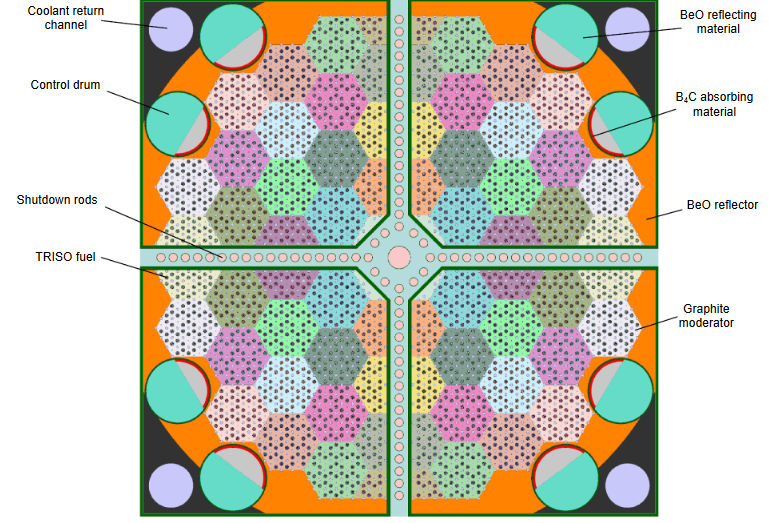


In [6]:
import pyMAISE as mai
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import uniform, randint
from sklearn.model_selection import ShuffleSplit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Plot settings
matplotlib_settings = {
    "font.size": 14,
    "legend.fontsize": 12,
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

Starting any pyMAISE job requires initialization, this includes the definition of global settings used throughout pyMAISE. For this problem the pyMAISE defaults are used:

- `verbosity`: 0 $\rightarrow$ pyMAISE prints no outputs,
- `random_state`: None $\rightarrow$ No random seed is set,
- `test_size`: 0.3 $\rightarrow$ 30% of the data is used for testing,
- `num_configs_saved`: 5 $\rightarrow$ The top 5 hyper-parameter configurations are saved for each model.

The settings are initialized and the heat conduction preprocessor specific to this data set is retrieved.

In [7]:
global_settings = mai.settings.init()
preprocessor = mai.load_qpower()

The data consists of 8 inputs:

In [8]:
preprocessor.inputs.head()

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8
0,5.919526,2.369503,2.923656,4.488987,3.683212,4.008905,4.970368,2.987966
1,2.162380,0.273624,0.927741,4.595586,2.598824,0.170167,2.124048,4.980209
2,0.450100,0.006301,2.512217,3.313864,1.913458,3.582252,0.280764,4.888595
3,0.461105,4.825628,3.771356,2.599278,2.056019,0.007332,1.106786,5.504671
4,5.248202,3.549416,3.333632,3.907310,2.095312,5.585145,3.774253,2.480120


and 4 outputs with 818 samples total. This data set is produced before preprocessing and added more samples using symmetry conditions.

In [9]:
preprocessor.outputs.head()

,fluxQ1,fluxQ2,fluxQ3,fluxQ4
0,2.580000e+19,2.590000e+19,2.670000e+19,2.560000e+19
1,2.550000e+19,2.530000e+19,2.510000e+19,2.510000e+19
2,2.570000e+19,2.580000e+19,2.520000e+19,2.520000e+19
3,2.570000e+19,2.580000e+19,2.520000e+19,2.560000e+19
4,2.540000e+19,2.620000e+19,2.580000e+19,2.520000e+19


The last step for preprocessing the data will be min-max scaling,

In [10]:
data = preprocessor.min_max_scale()

## Model Initialization
As this data set had a multi-dimensional output, we will hyper-parameter 6 models:

- Linear regression: `linear`,
- Lasso regression: `lasso`,
- Decision tree regression: `dtree`,
- Random forest regression: `rforest`,
- K-nearest neighbors regression: `knn`,
- Sequential Dense Neural Networks: `nn`.

All the classical models are initialized with the Scikit-learn defaults; however, the neural networks require some paramter definitions for the layers, optimizer, and training.

In [227]:
model_settings = {
    "models": ["linear", "lasso", "dtree", "knn", "rforest", "nn"],
    "nn": {
        # Sequential
        "num_layers": 5,
        "dropout": True,
        "rate": 0.4,
        "validation_split": 0.20,
        "loss": "mean_absolute_error",
        "metrics": ["mean_absolute_error"],
        "batch_size": 8,
        "epochs": 160,
        "warm_start": True,
        "jit_compile": False,
        # Starting Layer
        "start_num_nodes": 400,
        "start_kernel_initializer": "normal",
        "start_activation": "relu",
        "input_dim": preprocessor.inputs.shape[1], # Number of inputs
        # Middle Layers
        "mid_num_node_strategy": "linear", # Middle layer nodes vary linearly from 'start_num_nodes' to 'end_num_nodes'
        "mid_kernel_initializer": "normal",
        "mid_activation": "relu",
        # Ending Layer
        "end_num_nodes": preprocessor.outputs.shape[1], # Number of outputs
        "end_activation": "linear",
        "end_kernel_initializer": "normal",
        # Optimizer
        "optimizer": "adam",
        "learning_rate": 9e-4,
    },
}
tuning = mai.Tuning(data=data, model_settings=model_settings)

## Hyper-parameter Tuning

As this data set had a multi-dimensional output, we will hyper-parameter 6 models:

- Linear regression: `linear`,
- Lasso regression: `lasso`,
- Decision tree regression: `dtree`,
- Random forest regression: `rforest`,
- K-nearest neighbors regression: `knn`,
- Sequential Dense Neural Networks: `nn`.

All the classical models are initialized with the Scikit-learn defaults; however, the neural networks require some paramter definitions for the layers, optimizer, and training.

In [228]:
random_search_spaces = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "rforest": {
        "n_estimators": randint(low=20, high=200), # 20 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=40), # 1 - 40
        "p": randint(low=1, high=10), # 1 - 10
    },
}
bayesian_search_spaces = {
    "nn": {
        "mid_num_node_strategy": ["constant", "linear"],
        "batch_size": [8, 64],
        "learning_rate": [1e-5, 0.001],
        "num_layers": [2, 8],
        "start_num_nodes": [25, 500],
    },
}

start = time.time()
random_search_configs = tuning.random_search(
    param_spaces=random_search_spaces, 
    models=["linear"] + list(random_search_spaces.keys()), 
    n_iter=300, 
    cv=ShuffleSplit(n_splits=5, test_size=0.20, random_state=global_settings.random_state),
)
bayesian_search_configs = tuning.bayesian_search(
    param_spaces=bayesian_search_spaces,
    models=bayesian_search_spaces.keys(),
    n_iter=50,
    cv=5,
)
stop = time.time()
print("Hyper-parameter tuning took " + str((stop - start) / 60) + " minutes to process.")

Hyper-parameter tuning search space was not provided for linear, doing manual fit
Hyper-parameter tuning took 54.83229525089264 minutes to process.


We can understand the hyper-parameter tuning of Bayesian search on the artificial neural network from the convergence plot below.

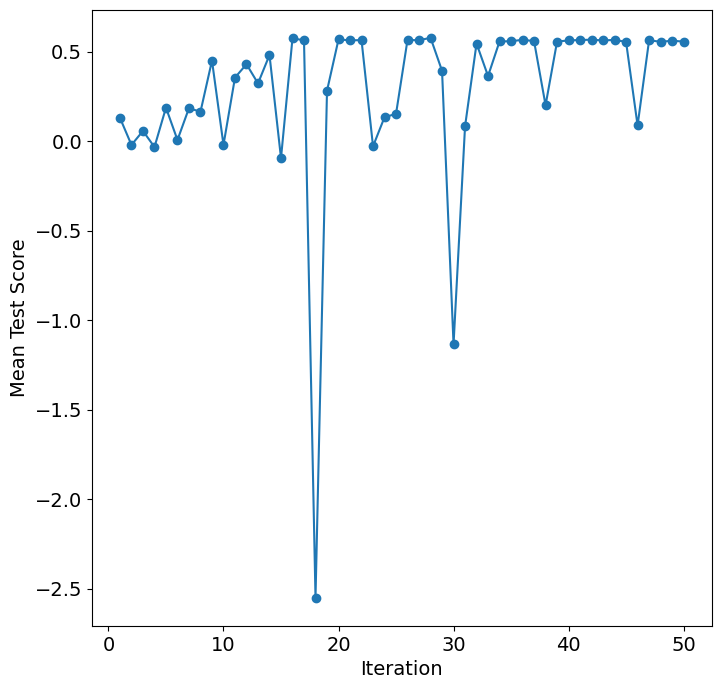

In [229]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(model_types="nn")

## Model Post-processing


With the top `num_configs_saved`, we can pass these parameter configurations to the `PostProcessor` for model comparison and analysis. For `nn` we define the `epochs` parameter to be 200 for better performance.

In [230]:
new_model_settings = {
    "nn": {"epochs": 200}
}
postprocessor = mai.PostProcessor(
    data=data, 
    models_list=[random_search_configs, bayesian_search_configs], 
    new_model_settings=new_model_settings,
    yscaler=preprocessor.yscaler,
)

To compare the performance of these models we will compute performance metrics for both the training and testing data: 


In [231]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
22,nn,"{'batch_size': 8, 'learning_rate': 0.000768934...",0.723310,2.016330e+17,6.760209e+34,2.600040e+17,0.587191,2.451123e+17,9.540215e+34,3.088724e+17
25,nn,"{'batch_size': 8, 'learning_rate': 0.000692753...",0.731648,1.987000e+17,6.557863e+34,2.560833e+17,0.583411,2.469003e+17,9.618025e+34,3.101294e+17
21,nn,"{'batch_size': 8, 'learning_rate': 0.000571544...",0.729042,1.994119e+17,6.625076e+34,2.573922e+17,0.581055,2.466079e+17,9.671373e+34,3.109883e+17
23,nn,"{'batch_size': 8, 'learning_rate': 0.000773010...",0.727562,1.987243e+17,6.657604e+34,2.580233e+17,0.578204,2.480338e+17,9.745415e+34,3.121765e+17
24,nn,"{'batch_size': 8, 'learning_rate': 0.001, 'mid...",0.731647,1.973733e+17,6.555374e+34,2.560346e+17,0.574763,2.475927e+17,9.832405e+34,3.135667e+17
12,rforest,"{'criterion': 'absolute_error', 'max_features'...",0.925803,1.071549e+17,1.810155e+34,1.345420e+17,0.459602,2.820568e+17,1.251527e+35,3.537692e+17
13,rforest,"{'criterion': 'poisson', 'max_features': 'sqrt...",0.921264,1.087454e+17,1.920709e+34,1.385896e+17,0.452958,2.844069e+17,1.265573e+35,3.557490e+17
14,rforest,"{'criterion': 'squared_error', 'max_features':...",0.852740,1.495281e+17,3.592513e+34,1.895393e+17,0.451911,2.842909e+17,1.269313e+35,3.562742e+17
11,rforest,"{'criterion': 'squared_error', 'max_features':...",0.821266,1.652528e+17,4.360925e+34,2.088283e+17,0.450488,2.857992e+17,1.271526e+35,3.565846e+17
15,rforest,"{'criterion': 'squared_error', 'max_features':...",0.836304,1.580934e+17,3.992762e+34,1.998190e+17,0.441457,2.872441e+17,1.294109e+35,3.597373e+17


From each model we can see poor performance. The significant performer is the artificial neural network (ANN) which is still not acceptable enough to consider this model for application.

In [232]:
for model in ["linear", "lasso", "dtree", "knn", "rforest", "nn"]:
    print(postprocessor.get_params(model_type=model), "\n")

  Model Types  copy_X  fit_intercept n_jobs   normalize  positive
0      linear    True           True   None  deprecated     False 

  Model Types     alpha
0       lasso  0.000433 

  Model Types  max_depth  max_features  min_samples_leaf  min_samples_split
0       dtree         41             2                14                  4 

  Model Types  leaf_size  n_neighbors  p   weights
0         knn         28           10  1  distance 

  Model Types       criterion  max_features  min_samples_leaf  \
0     rforest  absolute_error             4                 1   

   min_samples_split  n_estimators  
0                  2           174   

  Model Types  batch_size  learning_rate mid_num_node_strategy  num_layers  \
0          nn           8       0.000769              constant           2   

   start_num_nodes  
0              445   



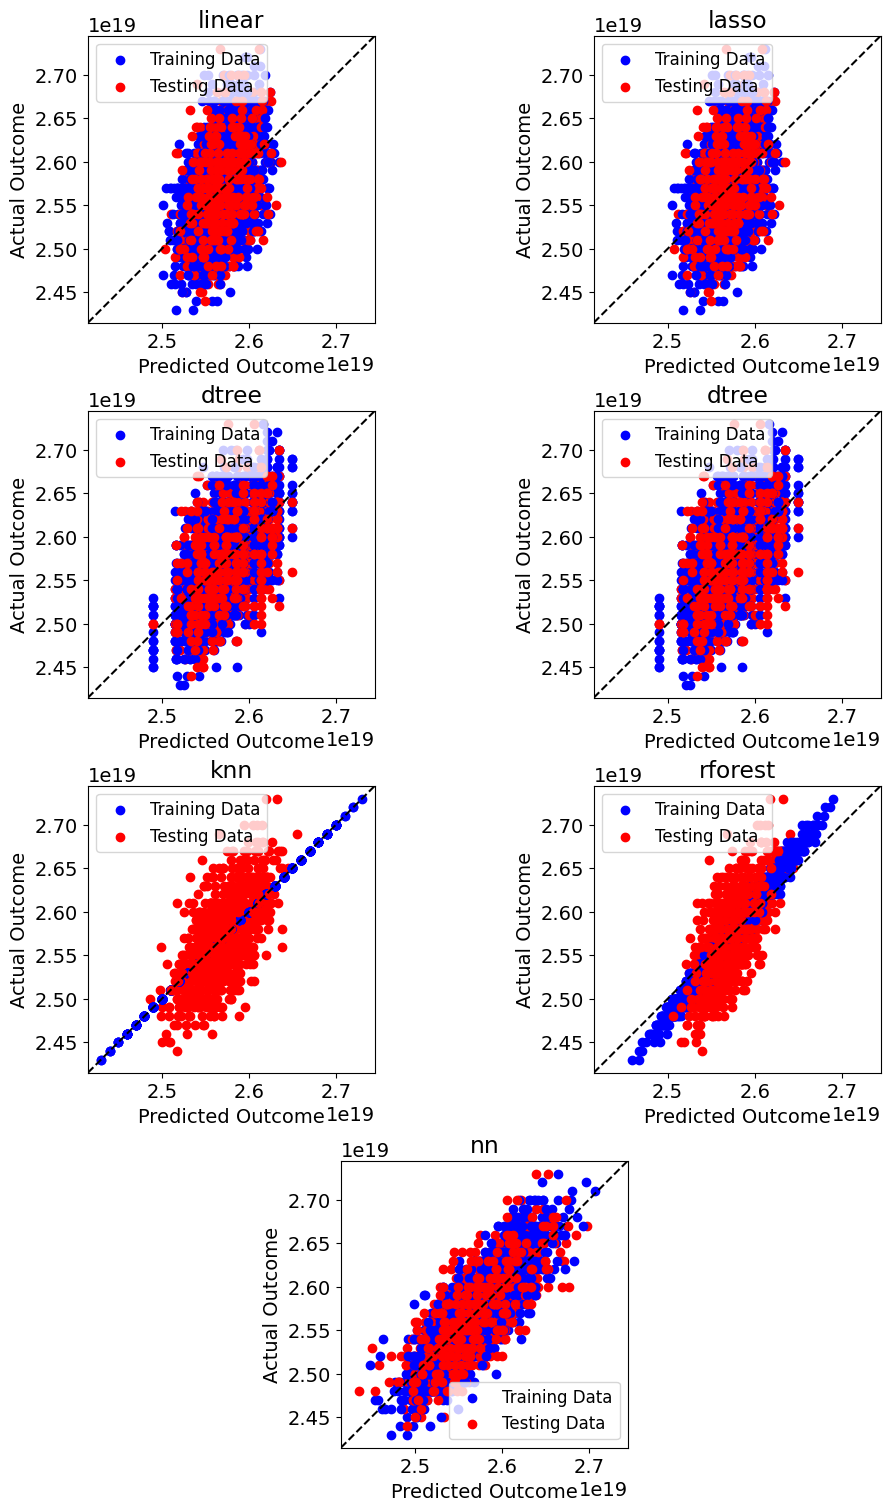

In [233]:
models = np.array([["linear", "lasso"], ["dtree", "dtree"], ["knn", "rforest"], ["nn", None]])

fig = plt.figure(constrained_layout=fig, figsize=(10,15))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0] - 1):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.diagonal_validation_plot(model_type=models[i, j])
            ax.set_title(models[i, j])
ax = fig.add_subplot(gs[-1, :])
ax = postprocessor.diagonal_validation_plot(model_type=models[-1, 0])
_ = ax.set_title(models[-1, 0])

Lastly we can see the `nn` traning curve. Due to loss being higher for validation one can assume this model cannot predict well.

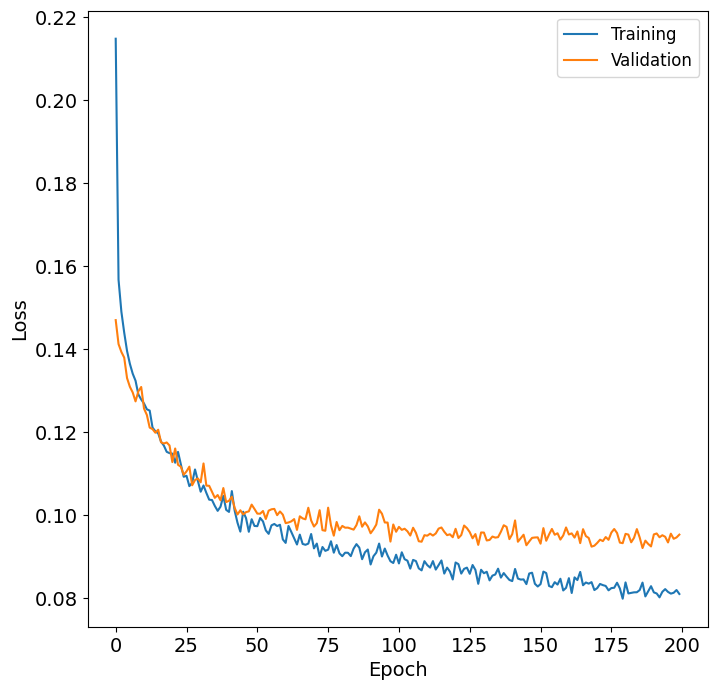

In [234]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()

# Updated data using reactor symmetries to multiply samples

To obtain better results, higher levels of preprocessing on the input file will have to be done. A function from https://github.com/deanrp2/MicroControl/blob/main/pmdata/ used in the [1] was used called `qpower_preprocessing`. This function applies the symmetry rules to multiply the samples, removes uneeded columns, adjusts the drum angles to be in the correct cordinate system and scales quadrant powers to sum to 1. This will expand the data set from about 818 samples to about 3004 samples.

Another function within the github repo will be used called `careful_split`.  This function gives the training and testing split without making samples
        that come from the same calculation end up on other sides of the split. It is only
        needed because we use symmetry to expand our sample space.


## pyMAISE Initialization  

In [11]:
global_settings = mai.settings.init()
preprocessor = mai.load_pqpower()

The data still consists of 8 inputs, but more samples.

In [12]:
preprocessor.inputs.head()

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8
0,2.237507,-1.698166,2.433453,1.253772,3.140399,-3.082829,2.754851,0.386800
1,1.253772,2.433453,-1.698166,2.237507,0.386800,2.754851,-3.082829,3.140399
2,-3.140399,3.082829,-2.754851,-0.386800,-2.237507,1.698166,-2.433453,-1.253772
3,-0.386800,-2.754851,3.082829,-3.140399,-1.253772,-2.433453,1.698166,-2.237507
4,-1.519638,2.489141,-1.853817,1.147173,-2.058398,0.755909,-0.091469,2.379043


The data still consists of  outputs:

In [13]:
preprocessor.outputs.head()

,fluxQ1,fluxQ2,fluxQ3,fluxQ4
0,0.248175,0.249199,0.256734,0.245892
1,0.249199,0.248175,0.245892,0.256734
2,0.256734,0.245892,0.248175,0.249199
3,0.245892,0.256734,0.249199,0.248175
4,0.252723,0.250798,0.248167,0.248312


The `careful_split` function from the github repo will then be used to split the into a training and testing split [1]. The function definition can be seen below 

In [238]:
def careful_split(df, tstfrac = False, tstnum = False):
    """
    Returns a train and test split which does not allow samples coming from the same calculation
    to exist across the train/test line. In other words, samples generated from symmetry must stay
    with the sample they were made from.

    df: must be dataframe with the indices given from the mult_sym function. make sure to sort_index
    tstfrac: generate the split based on an approximate fraction to include in the TESTING set
    tstnum: generate the split based on an approximate total number to include in the TESTING set. The argument here
        will be approximately the total number of rows in the testing dataframe that is returned
    """
    tot_samples = df.shape[0]

    #determine size of final testing set divided by 4
    if tstnum:
        tstsize = int(tstnum//4)
    elif tstfrac:
        tstsize = int((tot_samples*tstfrac)//4)
    else:
        raise Exception("Please specify tstfrac or tstsize")

    #get sample names associate with original calcs
    samplenums = np.unique([a[:12] for a in df.index])

    #pick a set from the original sample names
    tidxr = list(np.random.choice(samplenums, tstsize, replace = False))

    #expand set to include multiplied sample names as well
    tidxf = sorted(tidxr + [a + "_h" for a in tidxr] + [a + "_r" for a in tidxr] + [a + "_v" for a in tidxr])

    #index original dataframe to get the sets
    train = df.drop(tidxf)
    test = df.loc[tidxf]

    return train, test

The function is then used to split the data for the model to train off of. This splitting also was produced from the GitHub repo.

In [263]:
#load data
data = pd.read_csv("/home/connorcr//NERS491/pyMAISE/pyMAISE/data/qpower_processed.csv", index_col = 0)


#train and test split
train, test = careful_split(data, tstfrac = 0.2)

#define predictors and responses
pred = ["theta" + str(i) for i in range(1, 9)]
resp = ["fluxQ"+str(i) for i in range(1,5)]

#split into X/Y data arrays
xtrain=train[pred].values
xtest=test[pred].values

ytrain=train[resp].values
ytest=test[resp].values

# Putting data back into a pandas data frame for pyMAISE to use
data = ( pd.DataFrame(xtrain, columns=['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8']),  pd.DataFrame(xtest, columns=['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8']),  pd.DataFrame(ytrain, columns=['fluxQ1', 'fluxQ2', 'fluxQ3', 'fluxQ4']),  pd.DataFrame(ytest, columns=['fluxQ1', 'fluxQ2', 'fluxQ3', 'fluxQ4']))

# Model Initialization

Models were initialized the same as before.

In [240]:
model_settings = {
    "models": ["linear", "lasso", "dtree", "knn", "rforest", "nn"],
    "nn": {
        # Sequential
        "num_layers": 5,
        "dropout": False,
        "rate": 0.5,
        "validation_split": 0.20,
        "loss": "mean_absolute_error",
        "metrics": ["mean_absolute_error"],
        "batch_size": 8,
        "epochs": 200,
        "warm_start": True,
        "jit_compile": False,
        # Starting Layer
        "start_num_nodes": 437,
        "start_kernel_initializer": "normal",
        "start_activation": "relu",
        "input_dim": preprocessor.inputs.shape[1], # Number of inputs
        # Middle Layers
        "mid_num_node_strategy": "linear", # Middle layer nodes vary linearly from 'start_num_nodes' to 'end_num_nodes'
        "mid_kernel_initializer": "normal",
        "mid_activation": "relu",
        # Ending Layer
        "end_num_nodes": preprocessor.outputs.shape[1], # Number of outputs
        "end_activation": "linear",
        "end_kernel_initializer": "normal",
        # Optimizer
        "optimizer": "adam",
        "learning_rate": 9e-4,
    },
}
tuning = mai.Tuning(data=data, model_settings=model_settings)

# Hyper-parameter Tuning
The hyper-parameter tuning spaces are defined below. Major differences are the slightly expanded search space along with baysian search have double the amount of iterations and random search producing more models.

In [241]:
random_search_spaces = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
bayesian_search_spaces = {
    "nn": {
        "mid_num_node_strategy": ["constant", "linear"],
        "batch_size": [8, 64],
        "learning_rate": [1e-5, 0.001],
        "num_layers": [2, 8],
        "start_num_nodes": [25, 500],
    },
}

start = time.time()
random_search_configs = tuning.random_search(
    param_spaces=random_search_spaces, 
    models=["linear"] + list(random_search_spaces.keys()), 
    n_iter=400, 
    cv=ShuffleSplit(n_splits=5, test_size=0.20, random_state=global_settings.random_state),
)
bayesian_search_configs = tuning.bayesian_search(
    param_spaces=bayesian_search_spaces,
    models=bayesian_search_spaces.keys(),
    n_iter=100,
    cv=5,
)
stop = time.time()
print("Hyper-parameter tuning took " + str((stop - start) / 60) + " minutes to process.")

Hyper-parameter tuning search space was not provided for linear, doing manual fit
Hyper-parameter tuning took 481.1029209295909 minutes to process.


Once again a plot of the beysian search `nn` convergence is shown.

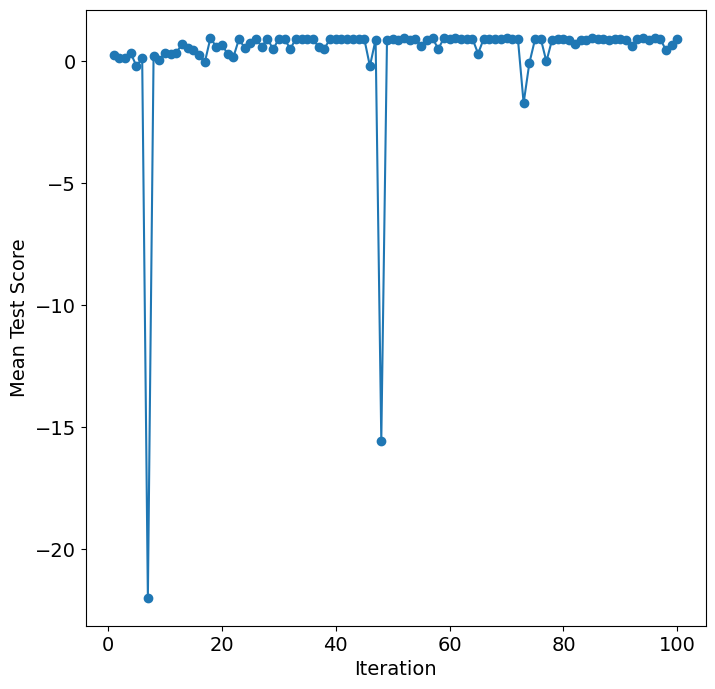

In [242]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(model_types="nn")


new_model_settings = {
    "nn": {"epochs": 200}
}
postprocessor = mai.PostProcessor(
    data=data, 
    models_list=[random_search_configs, bayesian_search_configs], 
    new_model_settings=new_model_settings,
    yscaler=preprocessor.yscaler,
)

The averaged performance matrics can be seen below.

In [243]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
21,nn,"{'batch_size': 10, 'learning_rate': 0.00071587...",0.988009,0.000354,2.083540e-07,0.000456,0.980992,0.000465,3.594479e-07,0.000600
23,nn,"{'batch_size': 8, 'learning_rate': 0.000469699...",0.960876,0.000653,6.797935e-07,0.000824,0.957822,0.000697,7.975876e-07,0.000893
22,nn,"{'batch_size': 8, 'learning_rate': 0.000536184...",0.957795,0.000669,7.333210e-07,0.000856,0.955604,0.000718,8.395288e-07,0.000916
25,nn,"{'batch_size': 8, 'learning_rate': 0.000557979...",0.951672,0.000726,8.397190e-07,0.000916,0.947478,0.000791,9.931777e-07,0.000997
24,nn,"{'batch_size': 8, 'learning_rate': 0.000394115...",0.938714,0.000812,1.064867e-06,0.001032,0.936472,0.000861,1.201305e-06,0.001096
11,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.957186,0.000683,7.439166e-07,0.000863,0.744293,0.001761,4.835391e-06,0.002199
13,rforest,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.954779,0.000702,7.857387e-07,0.000886,0.736210,0.001796,4.988249e-06,0.002233
15,rforest,"{'criterion': 'absolute_error', 'max_features'...",0.912795,0.000974,1.515221e-06,0.001231,0.735613,0.001795,4.999528e-06,0.002236
12,rforest,"{'criterion': 'squared_error', 'max_features':...",0.965586,0.000614,5.979644e-07,0.000773,0.732073,0.001804,5.066466e-06,0.002251
14,rforest,"{'criterion': 'squared_error', 'max_features':...",0.918623,0.000943,1.413963e-06,0.001189,0.724966,0.001827,5.200860e-06,0.002281


From this we can see that all the models performed significantly better with neural networks doing the best! To visualize this further diagonal validation plots and validations plots were ploduced below.

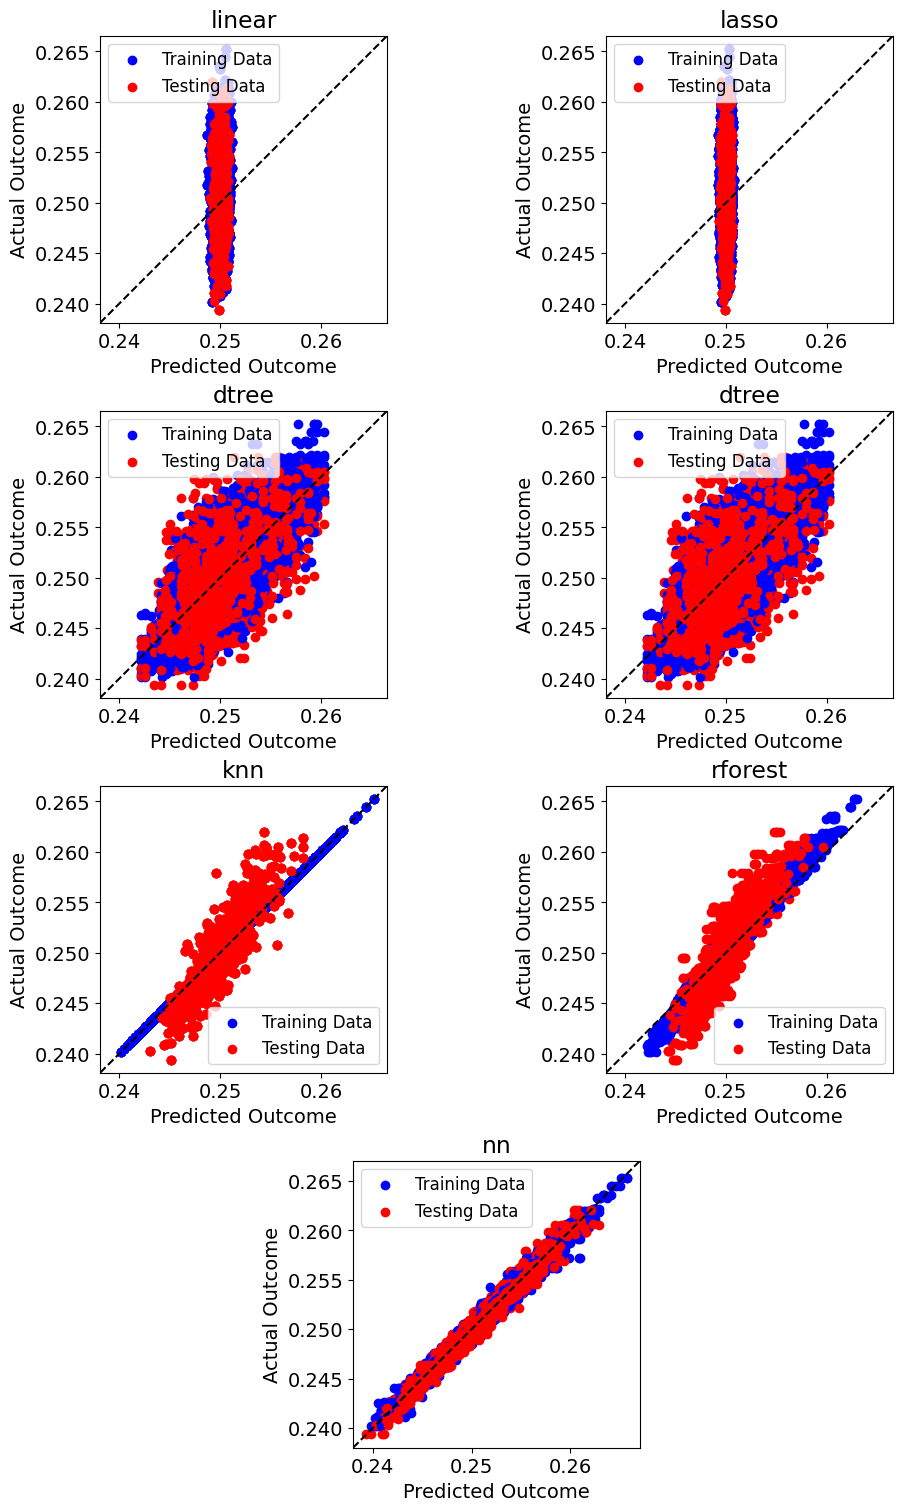

In [260]:
models = np.array([["linear", "lasso"], ["dtree", "dtree"], ["knn", "rforest"], ["nn", None]])

fig = plt.figure(constrained_layout=fig, figsize=(10,15))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0] - 1):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.diagonal_validation_plot(model_type=models[i, j])
            ax.set_title(models[i, j])
ax = fig.add_subplot(gs[-1, :])
ax = postprocessor.diagonal_validation_plot(model_type=models[-1, 0])
_ = ax.set_title(models[-1, 0])


Lastly the neural networks learning curve was produced to show there is no overfitting.

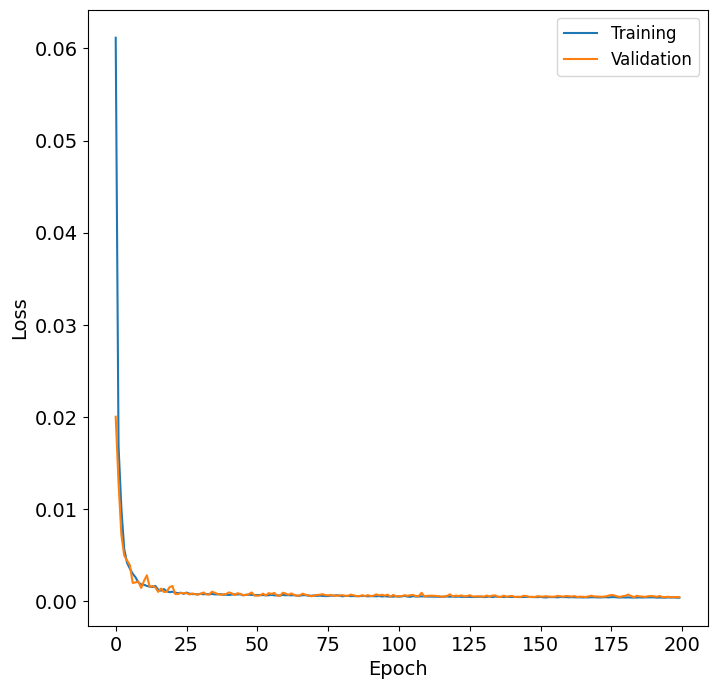

In [261]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()

# References
[1] Price, Dean & Radaideh, Majdi & Kochunas, Brendan. (2022). Multiobjective optimization of nuclear microreactor reactivity control system operation with swarm and evolutionary algorithms. Nuclear Engineering and Design. 393. 111776. 10.1016/j.nucengdes.2022.111776. 

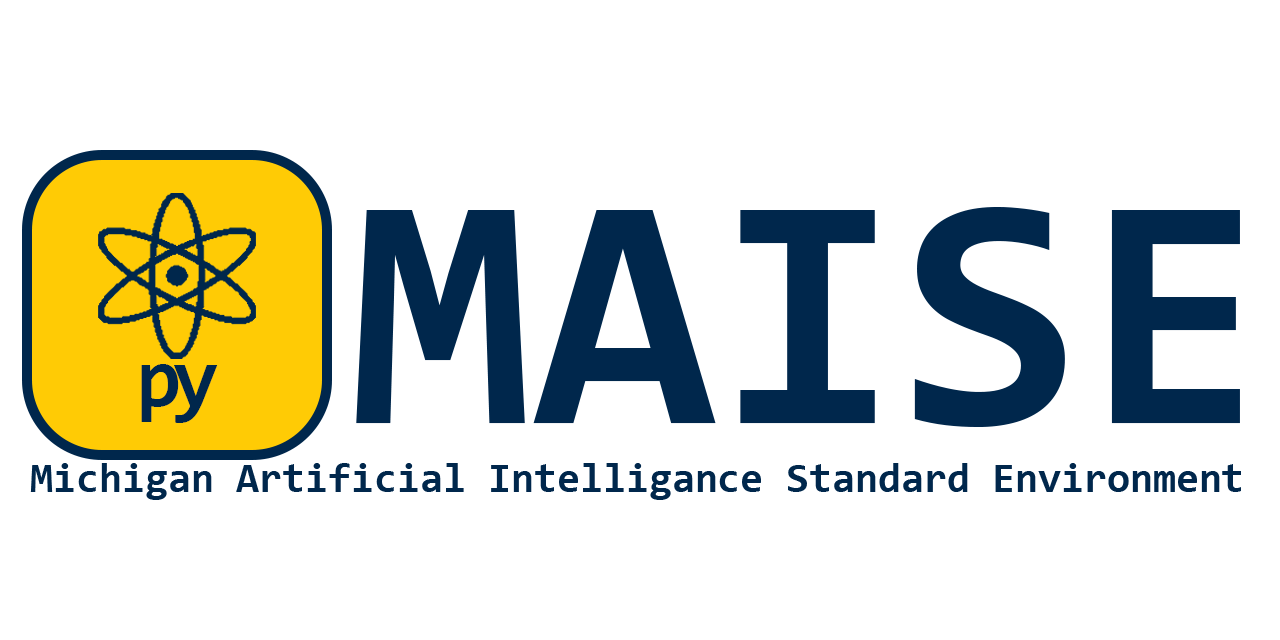